# Conditional variational autoencoder for prediction and feature recovery applied to intrusion detection in IoT

#### The purpose of a Network Intrusion Detection System is to detect intrusive, malicious activities or policy violations in a host or hosts network. In current networks, such a system is getting more important as the number and variety of attacks increase along with the volume and sensitiveness of the information exchanged. This is of particular interest to Internet of Things networks, where an intrusion detection system will be critical as its economic importance continues to grow, making it the focus of future intrusion attacks. In this work, we propose a new network intrusion detection method that is appropriate for an Internet of Things network. The proposed method is based on a Conditional Variational Autoencoder with a specific architecture that integrates the intrusion labels inside the decoder layers. The proposed method is less complex than other unsupervised methods based on a Variational Autoencoder and it provides better classification results than other familiar classifiers. More important, the method can perform feature reconstruction, that is, it is able to recover missing features from incomplete training datasets. We demonstrate that the reconstruction accuracy is very high, even for categorical features with a high number of distinct values. This work is unique in the network intrusion detection field, presenting the first application of a Conditional Variational Autoencoder and providing the first algorithm to perform feature recovery.


# 1. Prepare dataset
#### Load NSL-KDD dataset to perform training of the model and latter to assess its performance




In [1]:
# set working directory
import os
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/vae")

####################################################
# Load variables from previous session
####################################################
import dill
#dill.load_session('tf_NSL_KDD_Load.pkl')
load_from_pkl = True
if load_from_pkl:
    dill.load_session('tf_NSL_KDD20_Load_withWs.pkl')
    
os.chdir("W:/UVA/InvestigacionUVA/Informe proyecto 2017/Codigo_papers/cvae")
####################################################

In [2]:
import sklearn
sklearn.__version__

'0.18.1'

In [3]:
import lib
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder



## 1.1 Create Training and Test datasets
#### Next we need to prepare the test and train data with one-hot encoding. We need to scale also the training data as NN is sensitive to data scaling

In [4]:
if not load_from_pkl:
    # create Y, matrix 
    YTrain = dataTrain['class']
    YTest = dataTest['class']


    # create X, matrix 
    XTest = dataTest.drop(['class','difficulty'], axis = 1)
    XTrain = dataTrain.drop(['class','difficulty'], axis = 1)
    lenXTrain = len(XTrain)
    lenXTest = len(XTest)

    # extract continous features
    XTrainContinous = dataTrain.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)
    XTestContinous = dataTest.drop(['class','difficulty','protocol_type', 'service','flag'], axis = 1)

    # Eliminate columns which are mainly zeros
    t = XTrainContinous.apply(lambda x: sum(x != 0)) 
    minNumZeros = 100
    indexToErase = t[t<100].index
    XTrainContinous = XTrainContinous.drop(indexToErase, axis = 1)
    XTestContinous = XTestContinous.drop(indexToErase, axis = 1)

    # convert columns with continous data to categorical data, using a quantile over the values of each column.
    #XTrainContinousAsDis = XTrainContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    #XTestContinousAsDis = XTestContinous.apply(lambda x: pd.qcut(x, 20, labels=False))
    nBins = 40  # number of bins when doing the quantiles
    XTrainContinousAsDis = XTrainContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)
    XTestContinousAsDis = XTestContinous.apply(lambda x: lib.helpFun2 (x, nBins)).astype(str)

    # extract discrete features
    XTrainDiscrete = dataTrain.loc[:,['protocol_type', 'service','flag']]
    XTestDiscrete = dataTest.loc[:,['protocol_type', 'service','flag']]

    # normalize the continous features

    # apply log(x+1) transform to features with great range
    tXTest = XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]
    tXTrain = XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
    'num_root', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']]

    XTestContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                    'num_root', 'count', 'srv_count', 'dst_host_count', 
                    'dst_host_srv_count']] = tXTest.apply(lambda x: np.log(x+1), 0)
    XTrainContinous[['duration', 'src_bytes','dst_bytes','num_compromised',
                     'num_root', 'count', 'srv_count', 'dst_host_count',
                     'dst_host_srv_count']] = tXTrain.apply(lambda x: np.log(x+1), 0)
    # and then apply an additional min-max or standard scaler to all the continous features
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    XTrainContinous = pd.DataFrame(scaler.fit_transform(XTrainContinous), columns=XTrainContinous.columns)
    XTestContinous = pd.DataFrame(scaler.fit_transform(XTestContinous), columns=XTestContinous.columns)


    # get back the full training data sets
    #XTrainAll =pd.concat([XTrainContinousAsDis,XTrainDiscrete], axis=1)
    #XTestAll =pd.concat([XTestContinousAsDis,XTestDiscrete], axis=1)
    XTrainAll =pd.concat([XTrainContinous,XTrainDiscrete], axis=1)
    XTestAll =pd.concat([XTestContinous,XTestDiscrete], axis=1)

    # one-hot encode the categorical features
    XAll = XTrainAll.append(XTestAll, ignore_index = True)
    #col_names = list(XAll.columns.values)
    col_names = ['protocol_type', 'service','flag']
    XAll, _, _= lib.one_hot_dataframe(XAll, col_names, replace=True)

    # extract XTrain and XTest
    XTrain = XAll.ix[:lenXTrain-1]
    XTest = XAll.ix[lenXTrain:]


    #convert to matrix
    XTrainM = XTrain.as_matrix()
    XTestM = XTest.as_matrix()

    # one hot encode Y and convert to matrix
    YTrainM = YTrain.as_matrix()
    YTestM = YTest.as_matrix()

    # for the VAE
    XTrainContinousM = XTrainContinous.as_matrix()
    XTestContinousM = XTestContinous.as_matrix()
    XAllDiscrete = XTrainDiscrete.append(XTestDiscrete, ignore_index = True)
    XAllDiscrete, _, _= lib.one_hot_dataframe(XAllDiscrete, col_names, replace=True)
    XAllDiscrete_flg = XAllDiscrete.ix[:,:11]
    XAllDiscrete_prot = XAllDiscrete.ix[:,11:14]
    XAllDiscrete_srv = XAllDiscrete.ix[:,14:]
    XTrainDiscreteM = XAllDiscrete.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteM = XAllDiscrete.ix[lenXTrain:].as_matrix()
    XTrainDiscreteflgM = XAllDiscrete_flg.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteflgM = XAllDiscrete_flg.ix[lenXTrain:].as_matrix()
    XTrainDiscreteprotM = XAllDiscrete_prot.ix[:lenXTrain-1].as_matrix()
    XTestDiscreteprotM = XAllDiscrete_prot.ix[lenXTrain:].as_matrix()
    XTrainDiscretesrvM = XAllDiscrete_srv.ix[:lenXTrain-1].as_matrix()
    XTestDiscretsrveM = XAllDiscrete_srv.ix[lenXTrain:].as_matrix()

    num_features = XTrainM.shape[1]

    YTestAN = YTest.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTestANM = YTestAN.as_matrix()
    YTrainAN = YTrain.apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
    YTrainANM = YTrainAN.as_matrix()
    YTestAN5 =YTest.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTestAN5M = YTestAN5.as_matrix()
    YTrainAN5 = YTrain.apply(lambda x: 'NORMAL' if 'normal' in x else LabelToGroup[x])
    YTrainAN5M = YTrainAN5.as_matrix()

    # 23 labels
    lb = LabelBinarizer()
    lb.fit(YTrainM)
    #one-hot-encoded
    YTrainMOhe = lb.transform(YTrainM)
    YTestMOhe = lb.transform(YTestM) # this transformation changes YTest, as YTest has labels not present in YTrain

    # 5 labels
    lb5 = LabelBinarizer()
    lb5.fit(YTrainAN5M)
    #one-hot-encoded
    YTrainAN5MOhe = lb5.transform(YTrainAN5M)
    YTestAN5MOhe = lb5.transform(YTestAN5M) # this transformation changes YTest


    # 2 labels
    #one-hot-encoded
    YTrainANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTrainANM])
    YTestANMOhe = np.array([[1,0] if x== 'normal' else [0,1] for x in YTestANM])



In [5]:
XTrain.shape

(125973, 116)

## 1.2 Additional data preparation
### Additional data preparation needed to create additional features using the Non-negative Matrix Factorization algorithm. These features are not used in this project.

In [6]:
if not load_from_pkl:
    from sklearn.decomposition import NMF

    ## NMF
    # generate the W and H matrices for 23, 5 and components, and for Training and Testing

    nmf23 = NMF(n_components=23, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf23.fit(XTrainM) 
    W23Train = nmf23.transform(XTrainM)
    W23Test = nmf23.transform(XTestM)
    H23 =nmf23.components_


    nmf5 = NMF(n_components=5, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf5.fit(XTrainM) 
    W5Train = nmf5.transform(XTrainM)
    W5Test = nmf5.transform(XTestM)
    H5 =nmf5.components_


    nmf2 = NMF(n_components=2, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf2.fit(XTrainM) 
    W2Train = nmf2.transform(XTrainM)
    W2Test = nmf2.transform(XTestM)
    H2 =nmf2.components_

    nmf50 = NMF(n_components=50, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf50.fit(XTrainM) 
    W50Train = nmf50.transform(XTrainM)
    W50Test = nmf50.transform(XTestM)
    H50 =nmf50.components_

    from timeit import default_timer as timer
    start = timer()

    nmf75 = NMF(n_components=75, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf75.fit(XTrainM) 
    W75Train = nmf75.transform(XTrainM)
    W75Test = nmf75.transform(XTestM)
    H75 =nmf75.components_

    end = timer()
    print ("Time elapsed sec: {0}".format(end-start))

    from timeit import default_timer as timer
    start = timer()

    nmf100 = NMF(n_components=100, init='nndsvdar', solver='cd', tol=0.0001, 
                max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, 
                verbose=0, shuffle=False, nls_max_iter=2000)
    nmf100.fit(XTrainM) 
    W100Train = nmf100.transform(XTrainM)
    W100Test = nmf100.transform(XTestM)
    H100 =nmf100.components_

    end = timer()
    print ("Time elapsed: {0}".format(end-start))

    # create W matrices with all componets concatenated
    WAllTrain = np.concatenate((W23Train,W5Train,W2Train), axis=1)
    WAllTest = np.concatenate((W23Test,W5Test,W2Test), axis=1)

    # create new training and testing matrices with the original data plus all components coming from W for 23, 5 and 2 components
    XTrainExten = np.concatenate((XTrainM, WAllTrain), axis=1)
    XTestExten = np.concatenate((XTestM, WAllTest), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW23 = np.concatenate((XTrainM, W23Train), axis=1)
    XTestW23 = np.concatenate((XTestM, W23Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW5 = np.concatenate((XTrainM, W5Train), axis=1)
    XTestW5 = np.concatenate((XTestM, W5Test), axis=1)

    # create new training and testing matrices with the original data plus the compoenent coming from W23
    XTrainW2 = np.concatenate((XTrainM, W2Train), axis=1)
    XTestW2 = np.concatenate((XTestM, W2Test), axis=1)

### Datasets sizes

In [7]:
print(XTrainM.shape,YTrainMOhe.shape, XTestM.shape, YTestMOhe.shape, YTestM.shape)

(125973, 116) (125973, 23) (22544, 116) (22544, 23) (22544,)


## 1.3 Support functions
### Additional functions. These functions are support functions that will be used latter.

In [8]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

# given probability predictions return the one-hot encoded associated labels
def labelOHEncodedFromPrediction(predictions):
  return ((predictions == np.reshape(np.max(predictions, 1),(len(predictions),-1)))*1)

#transform back labels (one-hot encoded) to strings for the case of labels with 23 values
def invTransLabels(labels):
    return(lb.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 5 values
def invTransLabels5labels(labels):
    return(lb5.inverse_transform(labels))

#transform back labels (one-hot encoded) to strings for the case of labels with 2 values
def invTransLabels2labels(labels):
    return(np.array([ 'normal' if (x== [1,0]).all() else 'anomaly' for x in labels]))

def tf_rmse(x, y):
  return (tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(x,y)),1))))


def rmse(x, y):
  return np.sqrt(np.mean((x-y)**2))

In [9]:
#aa=np.array([[0.8, 0.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0.9, 0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
#labelOHEncodedFromPrediction(aa)

## 1.4 Functions to create training batchs
#### This function creates a new training dataset each time it is called

In [10]:
import time
import os
import math
from sklearn.model_selection import StratifiedKFold

class BatchTrainGen(object):

    def __init__(self, X, batch_size =100):
        self.X = X
        self.batch_size = batch_size
        
    def gen_offsets(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.roll(np.arange(self.X.shape[0]),-ini)
        
    def gen_offsets_random(self, ini = 0):
        self.batch_num = int(self.X.shape[0] / self.batch_size)
        self.indices = np.random.permutation(self.X.shape[0])

    def batch_num(self):
        return self.batch_num
    
    def next_batch(self):
        fold = self.indices[:self.batch_size]
        x_batch = self.X[fold,:]
        self.indices = np.roll(self.indices,-self.batch_size)
        return (x_batch, fold)


## 1.5 Create Keras and tensorflow sessions

In [11]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense
from keras.layers import Dropout
import keras

# attach keras and tensorflow
sess = tf.InteractiveSession()
K.set_session(sess)

tf.set_random_seed(1)

Using TensorFlow backend.


## 1.6 Functions to create different models

In [15]:

def config_nn_1(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1c(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(300, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,40]) # repeat the true labels n times
    xd2 = tf.concat(1,[xd1,labels_ext]) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd3 = Dropout(k)(xd3)
    xd3 = Dense(500, activation = f_activation)(xd3)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}

def config_nn_1b(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500, activation = f_activation)(z)  # fully-connected layer 
    xd = Dropout(k)(xd)
    xd = Dense(500, activation = f_activation)(xd)
    xd = Dropout(k)(xd)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'linear')(xd)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


def config_nn_1d(num_hidden_vars, f_activation = 'relu'):
    x_ini = tf.placeholder(tf.float32, [None, input_dim], name='x_ini')
    labels = tf.placeholder(tf.float32, [None, labels_dim], name='y')
    
    k= 1  # dropout probability
    # Keras layers can be called on TensorFlow tensors:
    #LR = keras.layers.advanced_activations.LeakyReLU(alpha=0)
    
    # encoder
    xe = Dense(500, activation = f_activation)(x_ini)  # fully-connected layer 
    xe = Dropout(k)(xe)
    xe = Dense(500, activation = f_activation)(xe)
    xe = Dropout(k)(xe)
    
    #posterior distributions
    z_mu = Dense(num_hidden_vars, activation = 'linear')(xe)
    z_log_sigma = Dense(num_hidden_vars, activation = 'linear')(xe)
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(z_log_sigma), name='epsilon')
    # Sample from posterior
    z = z_mu + tf.exp(z_log_sigma) * epsilon
    
    # decoder
    xd = Dense(500-5*label_repeat, activation = f_activation)(z)  # fully-connected layer 
    xd1 = Dropout(k)(xd)
    labels_ext = tf.tile(labels, [1,label_repeat]) # repeat the true labels n times
    xd2 = tf.concat([xd1,labels_ext],1) # concatenate the true labels repeated n times with the signals coming from z
    xd3 = Dense(500, activation = f_activation)(xd2)
    xd4 = Dropout(k)(xd3)
    
    #posterior distributions
    #yhat = Dense(output_dim,activation='softmax')(xd)  # if you use keras: categorical_crossentropy, you have to use softmax
    yhat = Dense(output_dim, activation = 'sigmoid')(xd4)
    
    return {'x_ini': x_ini, 'yhat': yhat, 'labels': labels, 'z_mu': z_mu, 'z_log_sigma' : z_log_sigma, 'z' : z}


# 2. Model CVAE from the paper


## 2.1 Model with all features

### 2.1.1 Train the model

Epoch 0 |Step 0 | Loss: 81.318756| KLD: 0.49140045046806335| BCE: 80.827354| Train rmse: 0.493076| Test rmse: 0.469280
Epoch 0 |Step 50 | Loss: 15.216488| KLD: 0.46715328097343445| BCE: 14.749334| Train rmse: 0.167476| Test rmse: 0.179176
Epoch 0 |Step 100 | Loss: 13.438962| KLD: 1.6384981870651245| BCE: 11.800464| Train rmse: 0.141296| Test rmse: 0.153925
Epoch 0 |Step 150 | Loss: 10.806928| KLD: 2.349843978881836| BCE: 8.457084| Train rmse: 0.108752| Test rmse: 0.133603
Epoch 0 |Step 200 | Loss: 11.016653| KLD: 2.004626512527466| BCE: 9.012027| Train rmse: 0.112725| Test rmse: 0.130563
Epoch 0 |Step 250 | Loss: 10.068013| KLD: 2.10062837600708| BCE: 7.967385| Train rmse: 0.103703| Test rmse: 0.127796
Epoch 0 |Step 300 | Loss: 10.113019| KLD: 2.1833064556121826| BCE: 7.929712| Train rmse: 0.103185| Test rmse: 0.122473
Epoch 0 |Step 350 | Loss: 9.570314| KLD: 2.170682907104492| BCE: 7.399632| Train rmse: 0.096553| Test rmse: 0.122742
Epoch 0 |Step 400 | Loss: 9.635486| KLD: 1.924595594

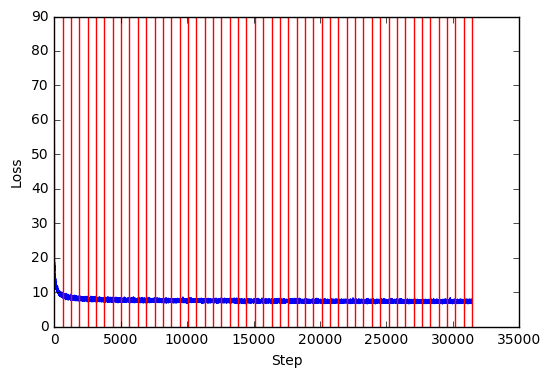

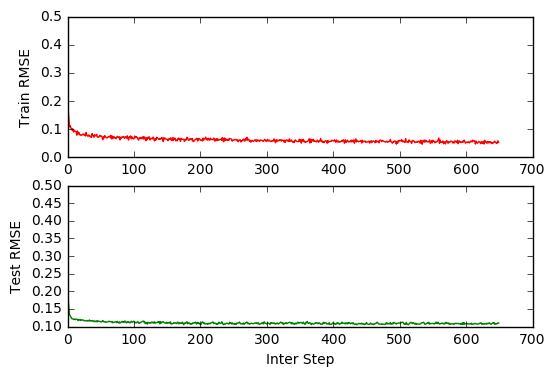

In [13]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

# change as you change the input and output data
xtraining = XTrainM
xtesting =  XTestM
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1d(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.1.2 Prediction of LABELS using all  features
### Aggregated metrics
#### To perform the prediction we use the Test dataset

In [ ]:
print('Counts')
print(YTestAN5.value_counts())
print('\nPercentage')
print(YTestAN5.value_counts().apply(lambda x: float(x)/sum(YTestAN5.value_counts()))*100)

In [32]:
def dist1(x,y):
    return (np.sqrt(np.mean(np.square(x-y),1)))
    
labels_names = np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])

# generamos matrices de labels iguales para hacer el test con una matriz de DOS, otra de R2L, etc...
labels_to_try = []
for n,i in enumerate(labels_names):
    labels_to_try.append(lb5.transform(np.array([i]*XTestM.shape[0])))

# forward pass con XtestM de entrada y 5 pasadas una por cada matrices de labels iguales
XTestM_hat_try = []
for n,i in enumerate(labels_names):
    XTestM_hat_try.append(cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: labels_to_try[n], 
                                            K.learning_phase(): 0}))

#calculamos la minima distancia de cada resultado de los cinco pases con las matrices de labels iguales con la matriz original de features
distances = pd.DataFrame(index=range(XTestM.shape[0]))
for n,i in enumerate(np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])):
    distances[n] = dist1(XTestM,XTestM_hat_try[n])
    
# a partir de los indices sacamos los labels del resultado de la prediccion
YTestMhat=np.array([labels_names[i] for i in distances.idxmin(axis=1)])

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print('\nPerformance measures. Test data')
print('Accuracy Test =  {}'.format(accuracy_score(YTestAN5M, YTestMhat)))
print('F1 =  {}'.format(f1_score(YTestAN5M, YTestMhat, average='weighted')))

print('Precision_score =  {}'.format(precision_score(YTestAN5M, YTestMhat, average='weighted')))

print('recall_score =  {}'.format(recall_score(YTestAN5M, YTestMhat, average='weighted')))

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(YTestAN5M, YTestMhat, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat


Performance measures. Test data
Accuracy Test =  0.767876153300213
F1 =  0.7596052750035365
Precision_score =  0.787974703816497
recall_score =  0.767876153300213
Confusion matrix:    Rows -> truth, Columns -> predictions


col_0           DOS       NORMAL        PROBE         R2L         U2R  \
row_0                                                                   
DOS     6242.000000    961.00000    62.000000  127.000000   66.000000   
NORMAL    87.000000   8574.00000   667.000000   21.000000  362.000000   
PROBE    252.000000    297.00000  1768.000000   68.000000   36.000000   
R2L        0.000000   1672.00000    17.000000  657.000000  208.000000   
U2R        0.000000    305.00000    21.000000    4.000000   70.000000   
All     6581.000000  11809.00000  2535.000000  877.000000  742.000000   
Perc       0.291918      0.52382     0.112447    0.038902    0.032913   

col_0       All      Perc  
row_0                      
DOS      7458.0  0.330820  
NORMAL   9711.0  0.430758  
PROBE    2421.0  0.107390  
R2L      2554.0  0.113290  
U2R       400.0  0.017743  
All     22544.0  0.000000  
Perc        1.0  0.000000

### 2.1.3 Prediction of LABELS using all  features
### One vs rest metrics
#### To perform the prediction we use the Test dataset

In [ ]:
yt_app = YTestAN5.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(YTestAN5.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(YTestAN5.value_counts().index):
    y_test_hat_check = YTestMhat.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = YTestAN5.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

## 2.2  Feature reconstruction when the feature: "protocol" is missing

### 2.2.1 Train the model

In [13]:
## the start and end of the discrete features are flags 32,43  protocol 43,46  service 46, fin

Epoch 0 |Step 0 | Loss: 81.047142| KLD: 0.409013956785202| BCE: 80.638130| Train rmse: 0.492360| Test rmse: 0.466344
Epoch 0 |Step 50 | Loss: 15.276201| KLD: 0.6593924760818481| BCE: 14.616809| Train rmse: 0.165550| Test rmse: 0.175902
Epoch 0 |Step 100 | Loss: 13.314454| KLD: 1.7272382974624634| BCE: 11.587215| Train rmse: 0.138197| Test rmse: 0.148414
Epoch 0 |Step 150 | Loss: 11.725621| KLD: 2.0091803073883057| BCE: 9.716441| Train rmse: 0.121399| Test rmse: 0.139226
Epoch 0 |Step 200 | Loss: 11.518836| KLD: 1.909815788269043| BCE: 9.609020| Train rmse: 0.120568| Test rmse: 0.133301
Epoch 0 |Step 250 | Loss: 10.469812| KLD: 2.13862681388855| BCE: 8.331185| Train rmse: 0.106632| Test rmse: 0.129566
Epoch 0 |Step 300 | Loss: 10.165499| KLD: 2.1655759811401367| BCE: 7.999923| Train rmse: 0.102550| Test rmse: 0.126132
Epoch 0 |Step 350 | Loss: 9.845415| KLD: 2.1066415309906006| BCE: 7.738774| Train rmse: 0.101887| Test rmse: 0.124906
Epoch 0 |Step 400 | Loss: 9.635531| KLD: 2.0702943801

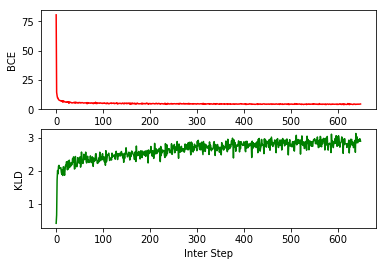

In [16]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

features_to_delete = list(range(43,46))

# change as you change the input and output data
xtraining = np.delete(XTrainM,features_to_delete,1)
xtesting =  np.delete(XTestM,features_to_delete,1)
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1d(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.2.2 Prediction of the "protocol" feature
### Aggregated metrics
#### To perform the prediction we use the Test dataset

In [17]:
def dist1(x,y):
    return (np.sqrt(np.mean(np.square(x-y),1)))
    
labels_names = np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])

labels_to_try = []
for n,i in enumerate(labels_names):
    labels_to_try.append(lb5.transform(np.array([i]*XTestM.shape[0])))

XTestM_hat_try = []
for n,i in enumerate(labels_names):
    XTestM_hat_try.append(cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: labels_to_try[n], 
                                            K.learning_phase(): 0}))
    
# to calculate distances we use all the features minus protocol 
distances = pd.DataFrame(index=range(XTestM.shape[0]))
for n,i in enumerate(np.array(['DOS', 'NORMAL', 'PROBE', 'R2L', 'U2R'])):
    distances[n] = dist1(xtesting, np.delete(XTestM_hat_try[n], features_to_delete, 1))
    

YTestMhatCVAE=np.array([labels_names[i] for i in distances.idxmin(axis=1)])

In [18]:
# We use the labels predictions just obtained to predict the best complete features set.
XTestToPredictFeature = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: lb5.transform(YTestMhatCVAE), 
                                            K.learning_phase(): 0})

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

XTestM_new = XTestM[:,features_to_delete]
XTestMhat_new = labelOHEncodedFromPrediction(XTestToPredictFeature[:,features_to_delete])
print('\nPerformance measures. Test data')
print('Accuracy Feature protocol =  {}'.format(accuracy(XTestM_new, 
                                                        XTestMhat_new)))
print('F1 =  {}'.format(f1_score(XTestM_new, 
                                XTestMhat_new, average='weighted')))

print('Precision_score =  {}'.format(precision_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))

print('recall_score =  {}'.format(recall_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))


Performance measures. Test data
Accuracy Feature protocol =  0.991305890702626
F1 =  0.9913008833255084
Precision_score =  0.9912965176550241
recall_score =  0.991305890702626


In [20]:
import lib
# one-hot encode the categorical features
t = XTrainAll.append(XTestAll, ignore_index = True)
#col_names = list(XAll.columns.values)
col_names = ['protocol_type', 'service','flag']
t, vecdata, vec= lib.one_hot_dataframe(t, col_names, replace=True)
#t.columns[32:]
a=np.zeros([XTestM_new.shape[0],11])
b=np.zeros([XTestM_new.shape[0],3])
c=np.zeros([XTestM_new.shape[0],70])

tt=np.concatenate((a,XTestM_new, c), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
tmp.columns=[i.replace("protocol_type=","") for i in tmp.columns.tolist()]
tmp=tmp.fillna(0)
XTestM_new_ohe=tmp.idxmax(axis=1)

tt=np.concatenate((a,XTestMhat_new, c), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
protocol=tmp
protocol.columns=[i.replace("protocol_type=","") for i in protocol.columns.tolist()]
protocol=protocol.fillna(0)
XTestMhat_new_ohe=protocol.idxmax(axis=1)

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(XTestM_new_ohe, XTestMhat_new_ohe, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat

Confusion matrix:    Rows -> truth, Columns -> predictions


col_0         icmp           tcp          udp      All      Perc
row_0                                                           
icmp   1022.000000     19.000000     2.000000   1043.0  0.046265
tcp      13.000000  18791.000000    76.000000  18880.0  0.837473
udp       7.000000     79.000000  2535.000000   2621.0  0.116262
All    1042.000000  18889.000000  2613.000000  22544.0  0.000000
Perc      0.046221      0.837873     0.115907      1.0  0.000000

### 2.2.3 Prediction of the "protocol" feature
### One vs rest metrics
#### To perform the prediction we use the Test dataset

In [23]:
XTestM_new_ohe_pd= pd.Series(XTestM_new_ohe)
yt_app = XTestM_new_ohe_pd.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(XTestM_new_ohe_pd.unique())),columns=['name', 'acc','f1', 'pre','rec', 'fpr', 'npv'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(XTestM_new_ohe_pd.value_counts().index):
    y_test_hat_check = XTestMhat_new_ohe.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = XTestM_new_ohe_pd.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    tn, fp, fn, tp = confusion_matrix(yt_app,y_test_hat_check).ravel() 
    fpr = fp/(fp+tn)  # fp/(fp+tn)
    npv = tn/(tn+fn)  # tn/(tn+fn)
    perf_per_class.ix[i]=[x,ac,f1,pr,re,fpr,npv ]
# performance measures per class for test data
perf_per_class

name       acc        f1       pre       rec          fpr       npv
0   tcp  0.991705  0.995049  0.994812  0.995286    0.0267467   0.97565
1   udp  0.992725  0.968666  0.970149  0.967188   0.00391507  0.995685
2  icmp  0.998181  0.980336  0.980806  0.979866  0.000930189  0.999023

In [22]:
print('Counts')
print(XTestM_new_ohe_pd.value_counts())
print('\nPercentage')
print(XTestM_new_ohe_pd.value_counts().apply(lambda x: float(x)/sum(XTestM_new_ohe_pd.value_counts()))*100)

Counts
tcp     18880
udp      2621
icmp     1043
dtype: int64

Percentage
tcp     83.747339
udp     11.626153
icmp     4.626508
dtype: float64


## 2.3  Feature reconstruction when the feature: "flags" is missing

### 2.3.1 Train the model

In [14]:
#print(flag_num,protocol_num,srv_num)

In [ ]:
## the start and end of the discrete features are flags 32,43  protocol 43,46  service 46, fin

Epoch 0 |Step 0 | Loss: 81.965195| KLD: 0.37890130281448364| BCE: 81.586296| Train rmse: 0.496280| Test rmse: 0.472171
Epoch 0 |Step 50 | Loss: 15.684625| KLD: 0.2541729807853699| BCE: 15.430451| Train rmse: 0.174341| Test rmse: 0.181990
Epoch 0 |Step 100 | Loss: 12.651274| KLD: 1.7122557163238525| BCE: 10.939018| Train rmse: 0.132565| Test rmse: 0.152299
Epoch 0 |Step 150 | Loss: 11.081476| KLD: 1.9508657455444336| BCE: 9.130610| Train rmse: 0.117400| Test rmse: 0.136109
Epoch 0 |Step 200 | Loss: 11.241802| KLD: 2.0292000770568848| BCE: 9.212603| Train rmse: 0.116447| Test rmse: 0.132442
Epoch 0 |Step 250 | Loss: 10.330449| KLD: 2.1206817626953125| BCE: 8.209767| Train rmse: 0.107520| Test rmse: 0.130647
Epoch 0 |Step 300 | Loss: 10.671283| KLD: 1.9575756788253784| BCE: 8.713707| Train rmse: 0.111842| Test rmse: 0.127470
Epoch 0 |Step 350 | Loss: 9.950444| KLD: 1.8591735363006592| BCE: 8.091270| Train rmse: 0.106244| Test rmse: 0.126199
Epoch 0 |Step 400 | Loss: 9.535777| KLD: 1.97736

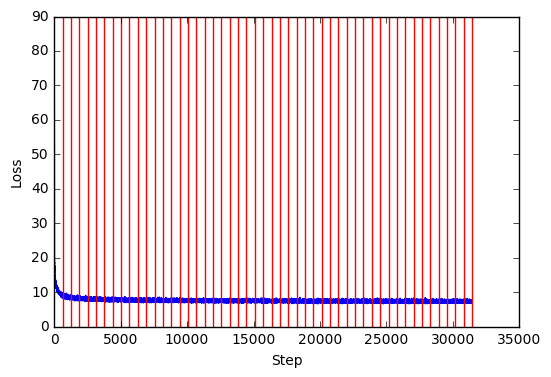

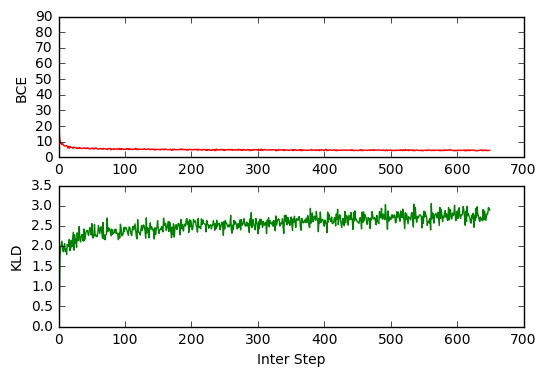

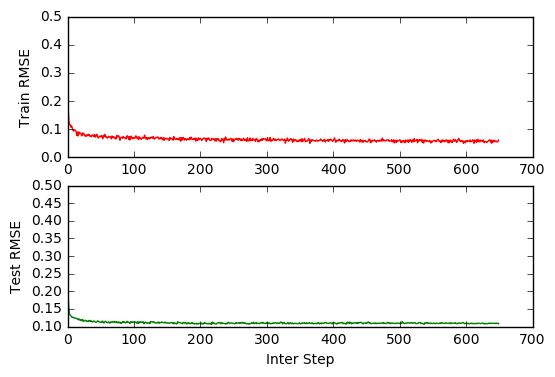

In [129]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

features_to_delete = list(range(32,43))

# change as you change the input and output data
xtraining = np.delete(XTrainM,features_to_delete,1)
xtesting =  np.delete(XTestM,features_to_delete,1)
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1d(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.3.2 Prediction of the "flags" feature
### Aggregated metrics
#### To perform the prediction we use the Test dataset

In [160]:
# We use the labels predictions just obtained to predict the best complete features set.
XTestToPredictFeature = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: lb5.transform(YTestMhatCVAE), 
                                            K.learning_phase(): 0})

In [161]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

XTestM_new = XTestM[:,features_to_delete]
XTestMhat_new = labelOHEncodedFromPrediction(XTestToPredictFeature[:,features_to_delete])
print('\nPerformance measures. Test data')
print('Accuracy Feature protocol =  {}'.format(accuracy(XTestM_new, 
                                                        XTestMhat_new)))
print('F1 =  {}'.format(f1_score(XTestM_new, 
                                XTestMhat_new, average='weighted')))

print('Precision_score =  {}'.format(precision_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))

print('recall_score =  {}'.format(recall_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))


Performance measures. Test data
Accuracy Feature protocol =  0.9284066713981547
F1 =  0.923978406191791
Precision_score =  0.9292601939705015
recall_score =  0.9284066713981547


d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [162]:
import lib
# one-hot encode the categorical features
t = XTrainAll.append(XTestAll, ignore_index = True)
#col_names = list(XAll.columns.values)
col_names = ['protocol_type', 'service','flag']
t, vecdata, vec= lib.one_hot_dataframe(t, col_names, replace=True)
#t.columns[32:]

a=np.zeros([XTestM_new.shape[0],11])
b=np.zeros([XTestM_new.shape[0],3])
c=np.zeros([XTestM_new.shape[0],70])

tt=np.concatenate((XTestM_new, b, c), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
tmp.columns=[i.replace("flag=","") for i in tmp.columns.tolist()]
tmp=tmp.fillna(0)
XTestM_new_ohe=tmp.idxmax(axis=1)

tt=np.concatenate((XTestMhat_new, b,c), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
protocol=tmp
protocol.columns=[i.replace("flag=","") for i in protocol.columns.tolist()]
protocol=protocol.fillna(0)
XTestMhat_new_ohe=protocol.idxmax(axis=1)

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(XTestM_new_ohe, XTestMhat_new_ohe, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat

Confusion matrix:    Rows -> truth, Columns -> predictions


col_0        OTH          REJ        RSTO        RSTR           S0  \
row_0                                                                
OTH     3.000000     0.000000    0.000000    1.000000     0.000000   
REJ     0.000000  3475.000000  106.000000   30.000000   121.000000   
RSTO    0.000000   294.000000  420.000000   13.000000    17.000000   
RSTOS0  0.000000     1.000000    0.000000    1.000000     0.000000   
RSTR    0.000000    31.000000   87.000000  304.000000   102.000000   
S0      0.000000    33.000000    5.000000    0.000000  1868.000000   
S1      0.000000     0.000000    0.000000    0.000000     0.000000   
S2      0.000000     0.000000    1.000000    0.000000     4.000000   
S3      0.000000     0.000000    4.000000    3.000000    11.000000   
SF      0.000000    54.000000   27.000000   32.000000     9.000000   
SH      0.000000     0.000000    0.000000    0.000000     0.000000   
All     3.000000  3888.000000  650.000000  384.000000  2132.000000   
Perc    0.000133     0.172463    0.028833    0.017033     0.094571   

col_0           S1        S2         S3            SF        SH      All  \
row_0                                                                      
OTH       0.000000  0.000000   0.000000      0.000000   0.00000      4.0   
REJ       4.000000  0.000000   0.000000    114.000000   0.00000   3850.0   
RSTO      0.000000  0.000000   3.000000     26.000000   0.00000    773.0   
RSTOS0    0.000000  0.000000   0.000000      0.000000   0.00000      2.0   
RSTR      0.000000  0.000000   0.000000    145.000000   0.00000    669.0   
S0       12.000000  0.000000   0.000000     95.000000   0.00000   2013.0   
S1        6.000000  1.000000   0.000000     14.000000   0.00000     21.0   
S2        3.000000  0.000000   0.000000      7.000000   0.00000     15.0   
S3      110.000000  1.000000  38.000000     61.000000  21.00000    249.0   
SF       10.000000  0.000000   0.000000  14743.000000   0.00000  14875.0   
SH        0.000000  0.000000   0.000000      0.000000  73.00000     73.0   
All     145.000000  2.000000  41.000000  15205.000000  94.00000  22544.0   
Perc      0.006432  0.000089   0.001819      0.674459   0.00417      1.0   

col_0       Perc  
row_0             
OTH     0.000177  
REJ     0.170777  
RSTO    0.034289  
RSTOS0  0.000089  
RSTR    0.029675  
S0      0.089292  
S1      0.000932  
S2      0.000665  
S3      0.011045  
SF      0.659821  
SH      0.003238  
All     0.000000  
Perc    0.000000

### 2.3.3 Prediction of the "flags" feature
### One vs Rest metrics
#### To perform the prediction we use the Test dataset

In [163]:
XTestM_new_ohe_pd= pd.Series(XTestM_new_ohe)
yt_app = XTestM_new_ohe_pd.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(XTestM_new_ohe_pd.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(XTestM_new_ohe_pd.value_counts().index):
    y_test_hat_check = XTestMhat_new_ohe.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = XTestM_new_ohe_pd.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


name       acc         f1        pre       rec
0       SF  0.973652   0.980253   0.969615  0.991126
1      REJ  0.965046   0.898165   0.893776  0.902597
2       S0  0.981858   0.901327   0.876173  0.927968
3     RSTO  0.974139   0.590302   0.646154  0.543338
4     RSTR  0.980261   0.577398   0.791667   0.45441
5       S3  0.990507   0.262069   0.926829   0.15261
6       SH  0.999068   0.874251   0.776596         1
7       S1  0.993169  0.0722892  0.0413793  0.285714
8       S2  0.999246          0          0         0
9      OTH  0.999956   0.857143          1      0.75
10  RSTOS0  0.999911          0          0         0

In [164]:
print('Counts')
print(XTestM_new_ohe_pd.value_counts())
print('\nPercentage')
print(XTestM_new_ohe_pd.value_counts().apply(lambda x: float(x)/sum(XTestM_new_ohe_pd.value_counts()))*100)

Counts
SF        14875
REJ        3850
S0         2013
RSTO        773
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
dtype: int64

Percentage
SF        65.982079
REJ       17.077715
S0         8.929205
RSTO       3.428850
RSTR       2.967530
S3         1.104507
SH         0.323811
S1         0.093151
S2         0.066537
OTH        0.017743
RSTOS0     0.008872
dtype: float64


## 2.4  Feature reconstruction when the feature: "service" is missing

### 2.4.1 Train the model

In [13]:
#print(flag_num,protocol_num,srv_num)

In [14]:
## the start and end of the discrete features are flags 32,43  protocol 43,46  service 46, fin

In [165]:
XTrainM.shape

(125973, 116)

Epoch 0 |Step 0 | Loss: 83.243347| KLD: 0.7995790839195251| BCE: 82.443771| Train rmse: 0.500094| Test rmse: 0.475982
Epoch 0 |Step 50 | Loss: 15.714422| KLD: 0.37385037541389465| BCE: 15.340571| Train rmse: 0.170594| Test rmse: 0.180694
Epoch 0 |Step 100 | Loss: 13.357691| KLD: 1.732334017753601| BCE: 11.625357| Train rmse: 0.139378| Test rmse: 0.146776
Epoch 0 |Step 150 | Loss: 11.032679| KLD: 2.02024507522583| BCE: 9.012433| Train rmse: 0.113553| Test rmse: 0.132312
Epoch 0 |Step 200 | Loss: 10.657108| KLD: 2.0103044509887695| BCE: 8.646804| Train rmse: 0.109687| Test rmse: 0.127700
Epoch 0 |Step 250 | Loss: 10.161502| KLD: 2.046398401260376| BCE: 8.115104| Train rmse: 0.104063| Test rmse: 0.125217
Epoch 0 |Step 300 | Loss: 9.918554| KLD: 1.8947689533233643| BCE: 8.023786| Train rmse: 0.101672| Test rmse: 0.125610
Epoch 0 |Step 350 | Loss: 9.671223| KLD: 2.055327892303467| BCE: 7.615894| Train rmse: 0.099662| Test rmse: 0.123597
Epoch 0 |Step 400 | Loss: 9.557680| KLD: 1.97362637519

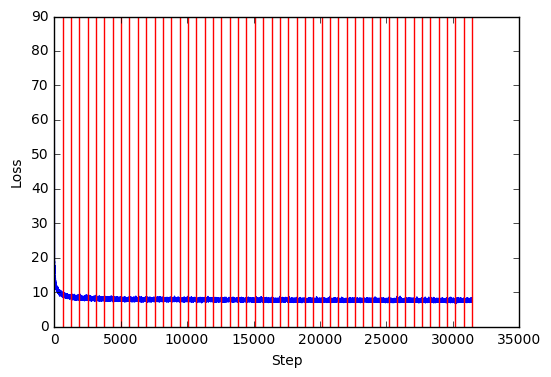

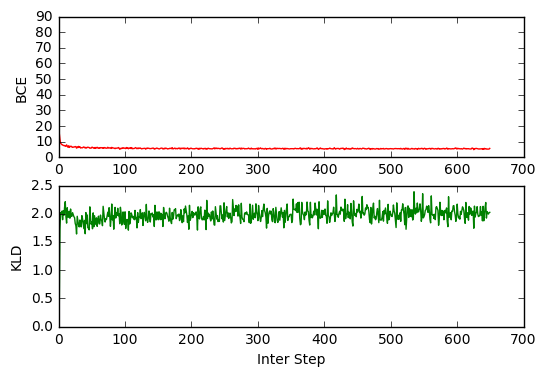

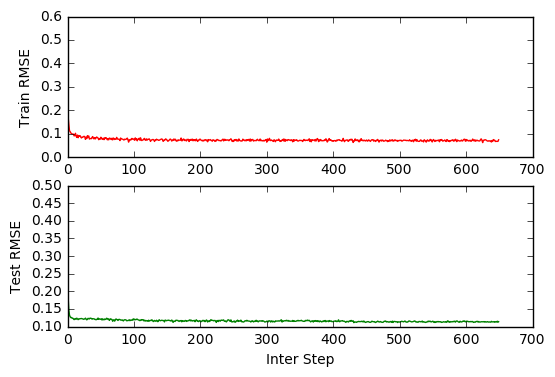

In [166]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

features_to_delete = list(range(46,116))

# change as you change the input and output data
xtraining = np.delete(XTrainM,features_to_delete,1)
xtesting =  np.delete(XTestM,features_to_delete,1)
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1d(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.4.2 Prediction of the "service" feature
### Aggregated metrics
#### To perform the prediction we use the Test dataset

In [291]:
# We use the labels predictions just obtained to predict the best complete features set.
XTestToPredictFeature = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: lb5.transform(YTestMhatCVAE), 
                                            K.learning_phase(): 0})

In [292]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

XTestM_new = XTestM[:,features_to_delete]
XTestMhat_new = labelOHEncodedFromPrediction(XTestToPredictFeature[:,features_to_delete])
print('\nPerformance measures. Test data')
print('Accuracy Feature protocol =  {}'.format(accuracy(XTestM_new, 
                                                        XTestMhat_new)))
print('F1 =  {}'.format(f1_score(XTestM_new, 
                                XTestMhat_new, average='weighted')))

print('Precision_score =  {}'.format(precision_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))

print('recall_score =  {}'.format(recall_score(XTestM_new, 
                                    XTestMhat_new, average='weighted')))


Performance measures. Test data
Accuracy Feature protocol =  0.7142476933995742
F1 =  0.6677927457023256
Precision_score =  0.6584411009621017
recall_score =  0.7142476933995742


d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [293]:
import lib
# one-hot encode the categorical features
t = XTrainAll.append(XTestAll, ignore_index = True)
#col_names = list(XAll.columns.values)
col_names = ['protocol_type', 'service','flag']
t, vecdata, vec= lib.one_hot_dataframe(t, col_names, replace=True)
#t.columns[32:]
a=np.zeros([XTestM_new.shape[0],11])
b=np.zeros([XTestM_new.shape[0],3])
c=np.zeros([XTestM_new.shape[0],70])

tt=np.concatenate((a,b,XTestM_new), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
tmp.columns=[i.replace("service=","") for i in tmp.columns.tolist()]
tmp=tmp.fillna(0)
XTestM_new_ohe=tmp.idxmax(axis=1)

tt=np.concatenate((a,b,XTestMhat_new), axis=1)
tmp=pd.DataFrame(vec.inverse_transform(tt))
protocol=tmp
protocol.columns=[i.replace("service=","") for i in protocol.columns.tolist()]
protocol=protocol.fillna(0)
XTestMhat_new_ohe=protocol.idxmax(axis=1)

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(XTestM_new_ohe, XTestMhat_new_ohe, margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat

Confusion matrix:    Rows -> truth, Columns -> predictions


col_0              IRC       auth   daytime    discard    domain    domain_u  \
row_0                                                                          
IRC          10.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
X11           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
Z39_50        0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
auth          0.000000   1.000000  0.000000   0.000000  0.000000    0.000000   
bgp           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
courier       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
csnet_ns      0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
ctf           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
daytime       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
discard       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
domain        0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
domain_u      0.000000   0.000000  0.000000   0.000000  0.000000  806.000000   
echo          0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
eco_i         0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
ecr_i         0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
efs           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
exec          0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
finger        0.000000   1.000000  0.000000   0.000000  0.000000    0.000000   
ftp           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
ftp_data      0.000000   0.000000  0.000000   0.000000  0.000000   13.000000   
gopher        0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
hostnames     0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
http         89.000000   0.000000  2.000000  18.000000  0.000000    7.000000   
http_443      0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
imap4         0.000000   2.000000  0.000000   0.000000  0.000000    0.000000   
iso_tsap      0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
klogin        0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
kshell        0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
ldap          0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
link          0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
...                ...        ...       ...        ...       ...         ...   
netstat       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
nnsp          0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
nntp          0.000000   1.000000  0.000000   0.000000  0.000000    0.000000   
ntp_u         0.000000   0.000000  0.000000   0.000000  0.000000    5.000000   
other         0.000000   1.000000  0.000000   0.000000  0.000000   11.000000   
pm_dump       0.000000   2.000000  0.000000   0.000000  0.000000    0.000000   
pop_2         0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
pop_3         3.000000   6.000000  0.000000   0.000000  1.000000    8.000000   
printer       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
private       0.000000   0.000000  0.000000   0.000000  0.000000  113.000000   
remote_job    0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
rje           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
shell         0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
smtp          0.000000   3.000000  0.000000   0.000000  0.000000    0.000000   
sql_net       0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
ssh           0.000000   0.000000  0.000000   0.000000  0.000000    0.000000   
sunrpc        0.000000   0.000000  0.000000   0.000000  0.000000    2.000000   


### 2.4.3 Prediction of the "service" feature
### One vs Rest metrics
#### To perform the prediction we use the Test dataset

In [294]:
XTestM_new_ohe_pd= pd.Series(XTestM_new_ohe)
yt_app = XTestM_new_ohe_pd.as_matrix()
perf_per_class = pd.DataFrame(index=range(len(XTestM_new_ohe_pd.unique())),columns=['name', 'acc','f1', 'pre','rec'])
#perf_per_class = pd.DataFrame(index=range(len(y_test['APP'].unique())),columns=['name', 'acc'])
for i,x in enumerate(XTestM_new_ohe_pd.value_counts().index):
    y_test_hat_check = XTestMhat_new_ohe.copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = XTestM_new_ohe_pd.as_matrix().copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.ix[i]=[x,ac,f1,pr,re]
# performance measures per class for test data
perf_per_class

d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


name       acc         f1        pre        rec
0          http  0.913857   0.879424   0.858112   0.901821
1       private  0.887908   0.774355   0.674864   0.908253
2        telnet   0.92366   0.243516    0.42681   0.170357
3         pop_3  0.954223  0.0282486   0.348837  0.0147203
4          smtp  0.964869   0.636029   0.557166   0.740899
5      domain_u  0.988911   0.865736   0.832645   0.901566
6      ftp_data   0.96203   0.636054   0.498334   0.878966
7         other  0.971611   0.586563   0.639437   0.541766
8         ecr_i  0.997383   0.960376   0.970149   0.950798
9           ftp  0.995609   0.927045   0.945865    0.90896
10        imap4  0.983543          0          0          0
11        eco_i  0.994855   0.809836    0.70977   0.942748
12       sunrpc  0.992947          0          0          0
13       finger  0.981281   0.178988   0.121693   0.338235
14         auth  0.995609   0.019802  0.0294118  0.0149254
15       domain  0.997693          0          0          0
16         uucp  0.986338   0.163043  0.0943396        0.6
17     iso_tsap  0.997871          0          0          0
18    uucp_path   0.99796          0          0          0
19          bgp   0.99796          0          0          0
20       Z39_50  0.998004          0          0          0
21        vmnet  0.998093          0          0          0
22         nnsp  0.998137          0          0          0
23         link  0.998181          0          0          0
24          ctf  0.998181          0          0          0
25      courier  0.998226          0          0          0
26        whois  0.998226          0          0          0
27         echo  0.998359          0          0          0
28         name  0.998359          0          0          0
29     http_443  0.998403          0          0          0
..          ...       ...        ...        ...        ...
34          efs  0.998536          0          0          0
35          mtp  0.998581          0          0          0
36       systat  0.998581          0          0          0
37        login  0.998669          0          0          0
38      daytime  0.998669          0          0          0
39         exec  0.998802          0          0          0
40       supdup  0.998802          0          0          0
41      netstat  0.998847          0          0          0
42      discard  0.998048          0          0          0
43          ssh  0.998447          0          0          0
44  netbios_dgm  0.998891          0          0          0
45       kshell  0.998935          0          0          0
46    hostnames   0.99898          0          0          0
47        urp_i  0.999246   0.622222   0.636364   0.608696
48         nntp  0.999068          0          0          0
49       klogin  0.999068          0          0          0
50         ldap  0.999157          0          0          0
51      sql_net  0.999202          0          0          0
52      pm_dump   0.99929          0          0          0
53        shell   0.99929          0          0          0
54          X11  0.999335          0          0          0
55  netbios_ssn  0.999335          0          0          0
56   remote_job  0.999379          0          0          0
57        pop_2  0.999423          0          0          0
58          IRC  0.995697    0.17094  0.0961538   0.769231
59      printer  0.999512          0          0          0
60        ntp_u  0.999512          0          0          0
61          rje  0.999645          0          0          0
62        tim_i  0.999734          0          0          0
63       tftp_u  0.999956          0          0          0

[64 rows x 5 columns]

In [295]:
print('Counts')
print(XTestM_new_ohe_pd.value_counts())
print('\nPercentage')
print(XTestM_new_ohe_pd.value_counts().apply(lambda x: float(x)/sum(XTestM_new_ohe_pd.value_counts()))*100)

Counts
http           7853
private        4774
telnet         1626
pop_3          1019
smtp            934
domain_u        894
ftp_data        851
other           838
ecr_i           752
ftp             692
imap4           306
eco_i           262
sunrpc          159
finger          136
auth             67
domain           51
uucp             50
iso_tsap         48
uucp_path        46
bgp              46
Z39_50           45
vmnet            43
nnsp             42
link             41
ctf              41
courier          40
whois            40
echo             37
name             37
http_443         36
               ... 
efs              33
mtp              32
systat           32
login            29
daytime          28
exec             27
supdup           27
netstat          26
discard          26
ssh              26
netbios_dgm      25
kshell           24
hostnames        23
urp_i            23
nntp             21
klogin           21
ldap             19
sql_net          18
pm_dump      

In [94]:
#sess.close()

## 2.5  Feature reconstruction when  all the continous features are missing

### 2.5.1 Train the model

In [13]:
#print(flag_num,protocol_num,srv_num)

In [14]:
## the start and end of the discrete features are flags 32,43  protocol 43,46  service 46, fin

In [33]:
XTrainM.shape

(125973, 116)

In [26]:
xtraining.shape

(125973, 113)

In [28]:
xtesting.shape

(22544, 113)

In [27]:
ytraining.shape

(125973, 116)

In [32]:
XTrain

duration  src_bytes  dst_bytes  wrong_fragment  hot  \
0       0.000000   0.294530   0.000000             0.0  0.0   
1       0.000000   0.237128   0.000000             0.0  0.0   
2       0.000000   0.000000   0.000000             0.0  0.0   
3       0.000000   0.259014   0.429008             0.0  0.0   
4       0.000000   0.251757   0.287837             0.0  0.0   
5       0.000000   0.000000   0.000000             0.0  0.0   
6       0.000000   0.000000   0.000000             0.0  0.0   
7       0.000000   0.000000   0.000000             0.0  0.0   
8       0.000000   0.000000   0.000000             0.0  0.0   
9       0.000000   0.000000   0.000000             0.0  0.0   
10      0.000000   0.000000   0.000000             0.0  0.0   
11      0.000000   0.000000   0.000000             0.0  0.0   
12      0.000000   0.269084   0.367717             0.0  0.0   
13      0.000000   0.276267   0.000000             0.0  0.0   
14      0.000000   0.000000   0.000000             0.0  0.0   
15      0.000000   0.000000   0.000000             0.0  0.0   
16      0.000000   0.271182   0.454033             0.0  0.0   
17      0.000000   0.139909   0.000000             0.0  0.0   
18      0.000000   0.259218   0.306045             0.0  0.0   
19      0.000000   0.277527   0.336890             0.0  0.0   
20      0.000000   0.000000   0.000000             0.0  0.0   
21      0.000000   0.000000   0.000000             0.0  0.0   
22      0.000000   0.263115   0.447039             0.0  0.0   
23      0.809232   0.237450   0.222140             0.0  0.0   
24      0.000000   0.000000   0.000000             0.0  0.0   
25      0.584098   0.289006   0.456171             0.0  0.0   
26      0.000000   0.000000   0.000000             0.0  0.0   
27      0.000000   0.257983   0.418856             0.0  0.0   
28      0.000000   0.255414   0.441053             0.0  0.0   
29      0.000000   0.260815   0.345108             0.0  0.0   
...          ...        ...        ...             ...  ...   
125943  0.000000   0.294530   0.000000             0.0  0.0   
125944  0.064982   0.362342   0.280776             0.0  0.0   
125945  0.000000   0.261979   0.318417             0.0  0.0   
125946  0.000000   0.000000   0.000000             0.0  0.0   
125947  0.000000   0.139909   0.000000             0.0  0.0   
125948  0.000000   0.000000   0.000000             0.0  0.0   
125949  0.000000   0.000000   0.000000             0.0  0.0   
125950  0.000000   0.160002   0.000000             1.0  0.0   
125951  0.000000   0.263301   0.301086             0.0  0.0   
125952  0.000000   0.340332   0.286460             0.0  0.0   
125953  0.000000   0.000000   0.000000             0.0  0.0   
125954  0.000000   0.266017   0.443008             0.0  0.0   
125955  0.000000   0.000000   0.000000             0.0  0.0   
125956  0.000000   0.163171   0.000000             0.0  0.0   
125957  0.064982   0.338759   0.275947             0.0  0.0   
125958  0.000000   0.000000   0.000000             0.0  0.0   
125959  0.000000   0.281500   0.403548             0.0  0.0   
125960  0.000000   0.275553   0.323281             0.0  0.0   
125961  0.000000   0.259823   0.376342             0.0  0.0   
125962  0.000000   0.167560   0.000000             0.0  0.0   
125963  0.000000   0.276267   0.351465             0.0  0.0   
125964  0.000000   0.000000   0.000000             0.0  0.0   
125965  0.000000   0.366426   0.281168             0.0  0.0   
125966  0.000000   0.000000   0.000000             0.0  0.0   
125967  0.000000   0.279687   0.282452             0.0  0.0   
125968  0.000000   0.000000   0.000000             0.0  0.0   
125969  0.205987   0.221590   0.237391             0.0  0.0   
125970  0.000000   0.366383   0.283579             0.0  0.0   
125971  0.000000   0.000000   0.000000             0.0  0.0   
125972  0.000000   0.238717   0.000000             0.0  0.0   

        num_failed_logins  logged_in  num_compromised  root_shell  num_root  \
0                     

Epoch 0 |Step 0 | Loss: 81.558487| KLD: 0.17050811648368835| BCE: 81.387978| Train rmse: 0.495536| Test rmse: 0.471574
Epoch 0 |Step 50 | Loss: 16.237310| KLD: 0.16450724005699158| BCE: 16.072803| Train rmse: 0.176711| Test rmse: 0.182884
Epoch 0 |Step 100 | Loss: 14.102577| KLD: 1.170647144317627| BCE: 12.931930| Train rmse: 0.152330| Test rmse: 0.167145
Epoch 0 |Step 150 | Loss: 12.048101| KLD: 1.6447384357452393| BCE: 10.403363| Train rmse: 0.128285| Test rmse: 0.141569
Epoch 0 |Step 200 | Loss: 11.150177| KLD: 1.814527153968811| BCE: 9.335649| Train rmse: 0.117037| Test rmse: 0.133040
Epoch 0 |Step 250 | Loss: 10.536242| KLD: 1.9612826108932495| BCE: 8.574959| Train rmse: 0.109854| Test rmse: 0.130004
Epoch 0 |Step 300 | Loss: 10.272413| KLD: 2.0705788135528564| BCE: 8.201835| Train rmse: 0.105346| Test rmse: 0.126849
Epoch 0 |Step 350 | Loss: 9.873042| KLD: 2.172020196914673| BCE: 7.701022| Train rmse: 0.101263| Test rmse: 0.124122
Epoch 0 |Step 400 | Loss: 9.598904| KLD: 2.101336

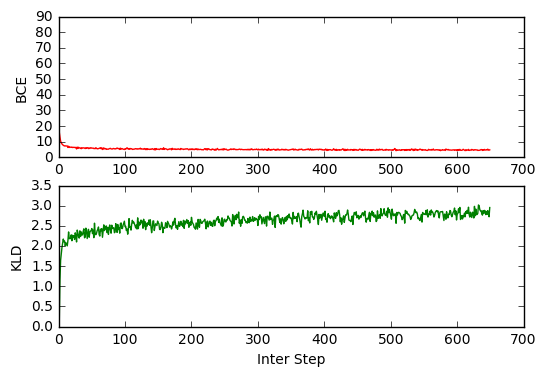

In [34]:
#tf.set_random_seed(123)
#np.random.seed(123)

from sklearn.metrics import mean_squared_error
from math import sqrt

features_to_delete = list(range(0,32))

# change as you change the input and output data
xtraining = np.delete(XTrainM,features_to_delete,1)
xtesting =  np.delete(XTestM,features_to_delete,1)
ytraining = XTrainM
ytesting =  XTestM

#input_dim = 116, out_dim = 23
input_dim = xtraining.shape[1]
output_dim = ytraining.shape[1]
labels_dim = 5
label_repeat = 1

#num_hidden_vars = 10
num_hidden_vars = 23
f_activation = 'relu'

#k = 1  # dropout probability
cnn = config_nn_1d(num_hidden_vars, f_activation)

y = tf.placeholder(tf.float32, [None, output_dim], name='y')

# p(x|z)
#log_px_given_z = tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'],y)
log_px_given_z = -tf.reduce_sum(
    y * tf.log(cnn['yhat'] + 1e-10) +
    (1 - y) * tf.log(1 - cnn['yhat'] + 1e-10), 1)

# d_kl(q(z|x)||p(z))
kl_div = -0.5 * tf.reduce_sum(
    1.0 + 2.0 * cnn['z_log_sigma'] - tf.square(cnn['z_mu']) - tf.exp(2.0 * cnn['z_log_sigma']),
    1)

KLD = tf.reduce_mean(kl_div)
BCE = tf.reduce_mean(log_px_given_z)
#BCE = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.sub(y,yhat)),1)))
#BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(cnn['yhat'], y)) 

loss = KLD + BCE 


learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess.run(tf.global_variables_initializer())

# Fit all training data
batch_size = 200
n_epochs = 50
print_step = 50


history = {'cost_h':[], 'train_rmse':[], 'test_rmse':[], 'kld':[], 'bce':[]}
for epoch in range(n_epochs):
    bt = BatchTrainGen(xtraining, batch_size)
    ini_offset = np.asscalar(np.random.randint(0,batch_size,1))
    bt.gen_offsets(ini_offset)
    # Loop over all batches
    for step in range(bt.batch_num):
        batch_xs, fold = bt.next_batch()
        batch_ys = ytraining[fold, :]
        batch_labels = YTrainAN5MOhe[fold, :]
        feed_dict = {cnn['labels']: batch_labels, cnn['x_ini']: batch_xs, y: batch_ys, K.learning_phase(): 1}
        cost, kld, bce, yhat, _ = sess.run([loss, KLD, BCE, cnn['yhat'], train_step], feed_dict = feed_dict)
        history['cost_h'].append(cost)

        if step % print_step == 0:
            batch_rmse = sqrt(mean_squared_error(batch_ys, yhat))
            test_rmse = sqrt(mean_squared_error(ytesting, 
                                                cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                                                            cnn['labels']: YTestAN5MOhe,
                                                                            K.learning_phase(): 0})))
            print("Epoch {0} |Step {1} | Loss: {2:.6f}| ".format(epoch,step,cost), end="")
            print("KLD: {0}| BCE: {1:.6f}| Train rmse: {2:.6f}| Test rmse: {3:.6f}".format(kld,
                                                                                           bce,
                                                                                           batch_rmse,
                                                                                           test_rmse))
            history['train_rmse'].append(batch_rmse)
            history['test_rmse'].append(test_rmse)
            history['kld'].append(kld)
            history['bce'].append(bce)


## Plot Loss
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history['cost_h'],'b-')
for xc in range(bt.batch_num,bt.batch_num*(n_epochs+1),bt.batch_num):
    plt.axvline(x=xc, color='r', linestyle='-')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show() 

## Plot kld and bce
plt.subplot(2, 1, 1)
plt.plot(history['bce'],'r-')
plt.ylabel('BCE')
plt.subplot(2, 1, 2)
plt.plot(history['kld'],'g-')
plt.ylabel('KLD')
plt.xlabel('Inter Step')
plt.show() 

## Plot Train Test rmse
plt.subplot(2, 1, 1)
plt.plot(history['train_rmse'],'r-')
plt.ylabel('Train RMSE')
plt.subplot(2, 1, 2)
plt.plot(history['test_rmse'],'g-')
plt.ylabel('Test RMSE')
plt.xlabel('Inter Step')
plt.show()   

### 2.5.2 Prediction of the continous features

In [47]:
# We use the labels predictions just obtained to predict the best complete features set.
XTestToPredictFeature = cnn['yhat'].eval(feed_dict={cnn['x_ini']: xtesting, 
                                            cnn['labels']: lb5.transform(YTestMhatCVAE), 
                                            K.learning_phase(): 0})

In [29]:
XTestM[:,features_to_delete].shape

(22544, 3)

In [52]:

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

print('\nPerformance measures. Test data')
print('Accuracy Feature protocol =  {}'.format(accuracy(XTestM[:,features_to_delete], 
                                                        XTestToPredictFeature[:,features_to_delete])))
print('F1 =  {}'.format(f1_score(XTestM[:,features_to_delete], 
                                            XTestToPredictFeature[:,features_to_delete], average='weighted')))

print('Precision_score =  {}'.format(precision_score(XTestM[:,features_to_delete], 
                                                XTestToPredictFeature[:,features_to_delete], average='weighted')))

print('recall_score =  {}'.format(recall_score(XTestM[:,features_to_delete], 
                                                XTestToPredictFeature[:,features_to_delete], average='weighted')))

print('Confusion matrix:    Rows -> truth, Columns -> predictions')
confusionMat = pd.crosstab(XTestM[:,features_to_delete], 
                                    XTestToPredictFeature[:,features_to_delete], margins = True)
# marginals in percentage
confusionMat['Perc'] = [i/(0.5*sum(confusionMat['All'])) for i in confusionMat['All'] ]
confusionMat.ix[-1,-1] = 0
confusionMat.loc['Perc'] = [i/(0.5*sum(confusionMat.loc['All'])) for i in confusionMat.loc['All'] ]
confusionMat


Performance measures. Test data
RMSE continous features =  0.1770744101452808


In [50]:
np.mean(XTestToPredictFeature)

0.081612989

In [51]:
np.mean(XTestM)

0.082223313475613097

In [24]:
features_to_delete

[43, 44, 45]

In [94]:
sess.close()